In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

# метрика Dice Coefficient

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

Будем работать с датасетом Cityscapes.

In [2]:
# Будем работать только с частью датасета, так как ресурсы на Kaggle ограничены
num_images_train = 80
num_images_val = 20


X_train = []
y_train = []

X_val = []
y_val = []


image_dir_train = '/content/drive/MyDrive/cityscapes_data/cityscapes_data/train'
image_dir_val = '/content/drive/MyDrive/cityscapes_data/cityscapes_data/val'
images_train = os.listdir(image_dir_train)
images_val = os.listdir(image_dir_val)

for filename in images_train[:num_images_train]:
    image = Image.open(os.path.join(image_dir_train, filename))
#     X_train.append(ImageOps.crop(image, (0, 0, 256, 0)))
#     y_train.append(ImageOps.crop(image, (256, 0, 0, 0)))
    X_train.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_train.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))
    

for filename in images_val[:num_images_val]:
    image = Image.open(os.path.join(image_dir_val, filename))
    X_val.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_val.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))


X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.

y_train = np.array(y_train)
y_val = np.array(y_val)

Построим сегментированные изображения с помощью кластеризации и затем сформируем датасет для обучения.

In [3]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
num_classes = 19
label_model = KMeans(n_clusters=num_classes, random_state=21)
label_model.fit(color_array)

KMeans(n_clusters=19, random_state=21)

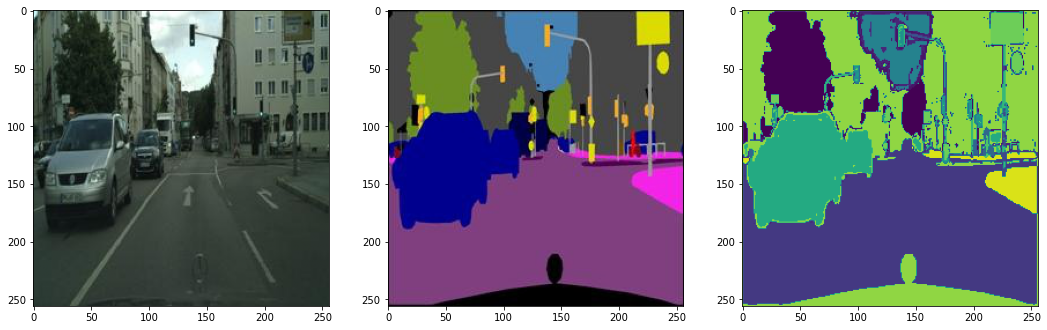

In [4]:
label_class = label_model.predict(y_train[3].reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])
axes[2].imshow(label_class)
plt.show()

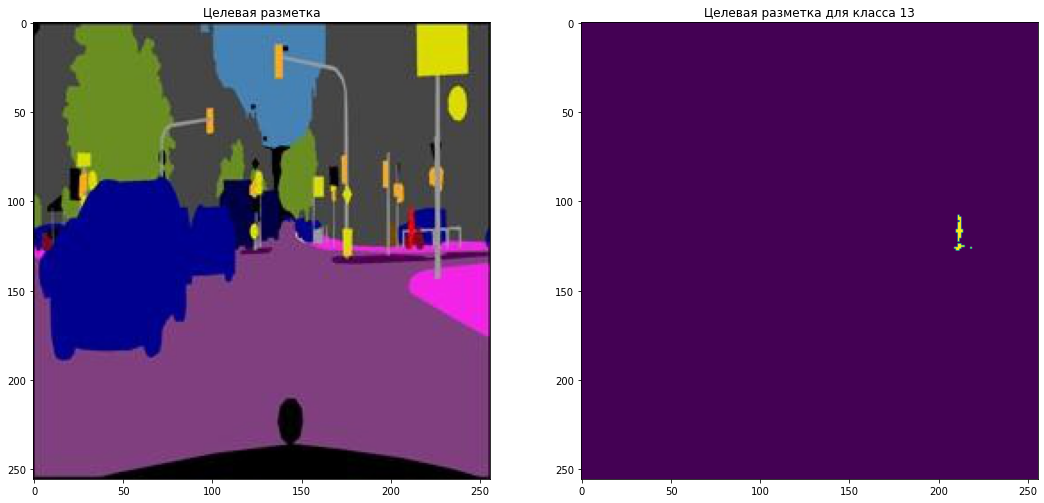

In [5]:
def Color2index(y, num_classes=19):
    arr_col = np.arange(0, num_classes)
    t = label_model.predict(y.reshape(-1, 3)).reshape(256, 256)
    y_cat = (arr_col == t[...,None]).astype(int)
    return y_cat, t

cat_yi,ind_yi = Color2index(y_train[3])

class_ = 13
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(y_train[3,:,:,:])
axes[0].title.set_text('Целевая разметка')
axes[1].imshow(cat_yi[:,:,class_])
axes[1].title.set_text(f'Целевая разметка для класса {class_}')
plt.show() 

Сформируем наборы выходных примеров для обучения и валидации.

In [6]:
train_labels = []
val_labels = []

for mask in y_train:
    y_cat,_ = Color2index(mask)
    train_labels.append(y_cat)


for mask in y_val:
    y_cat,_ = Color2index(mask)
    val_labels.append(y_cat)
    
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [7]:
train_labels.shape

(80, 256, 256, 19)

In [8]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

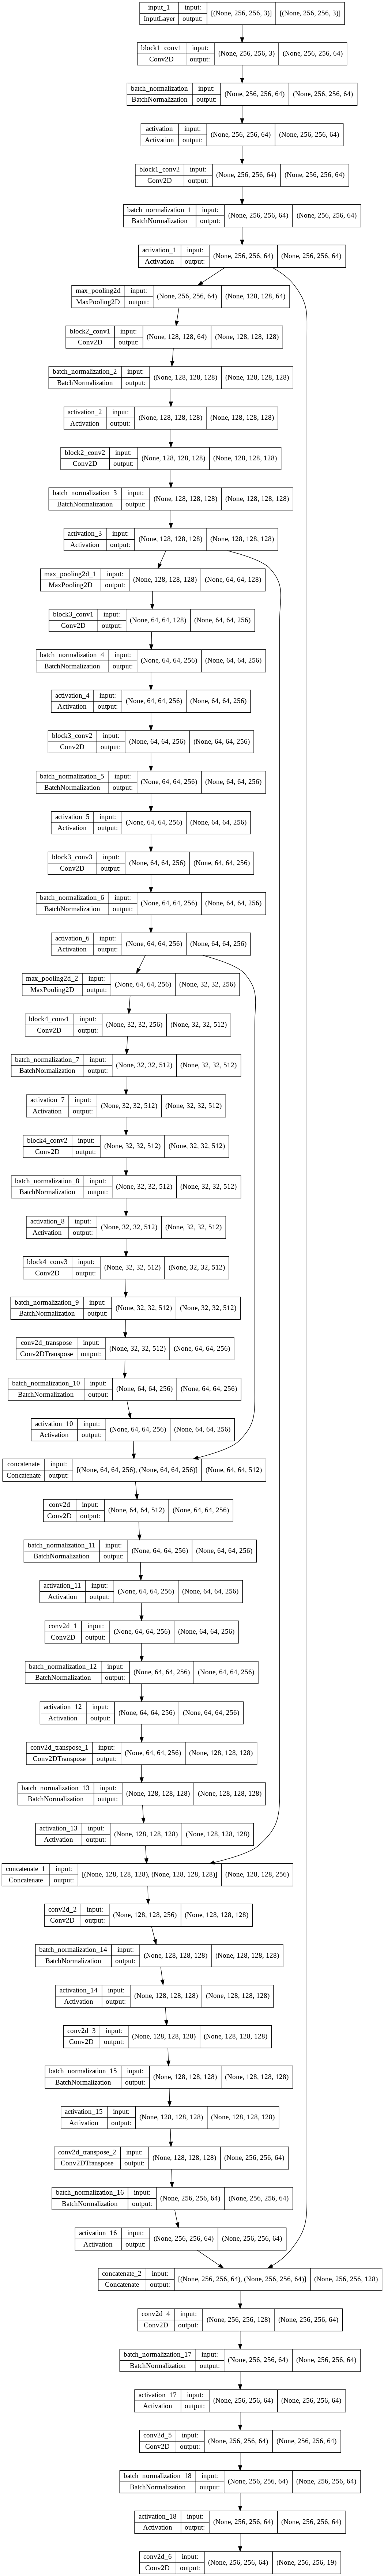

In [9]:
model_1 = Unet(19, (256, 256, 3))

plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [10]:
history = model_1.fit(X_train, train_labels, epochs=25, batch_size=1, validation_data=(X_val, val_labels))

Epoch 1/25
80/80 [==============================] - 33s 245ms/step - loss: 1.4425 - dice_coef: 0.4167 - val_loss: 3.7714 - val_dice_coef: 0.2897
Epoch 2/25
80/80 [==============================] - 19s 235ms/step - loss: 1.2174 - dice_coef: 0.4830 - val_loss: 5.5891 - val_dice_coef: 0.3370
Epoch 3/25
80/80 [==============================] - 19s 237ms/step - loss: 1.1336 - dice_coef: 0.5135 - val_loss: 12.8302 - val_dice_coef: 0.3356
Epoch 4/25
80/80 [==============================] - 19s 238ms/step - loss: 1.0881 - dice_coef: 0.5329 - val_loss: 2.9042 - val_dice_coef: 0.3169
Epoch 5/25
80/80 [==============================] - 20s 250ms/step - loss: 1.0561 - dice_coef: 0.5330 - val_loss: 4.5394 - val_dice_coef: 0.3671
Epoch 6/25
80/80 [==============================] - 19s 239ms/step - loss: 1.0282 - dice_coef: 0.5526 - val_loss: 2.6365 - val_dice_coef: 0.4066
Epoch 7/25
80/80 [==============================] - 19s 239ms/step - loss: 1.0016 - dice_coef: 0.5651 - val_loss: 4.8381 - val_di

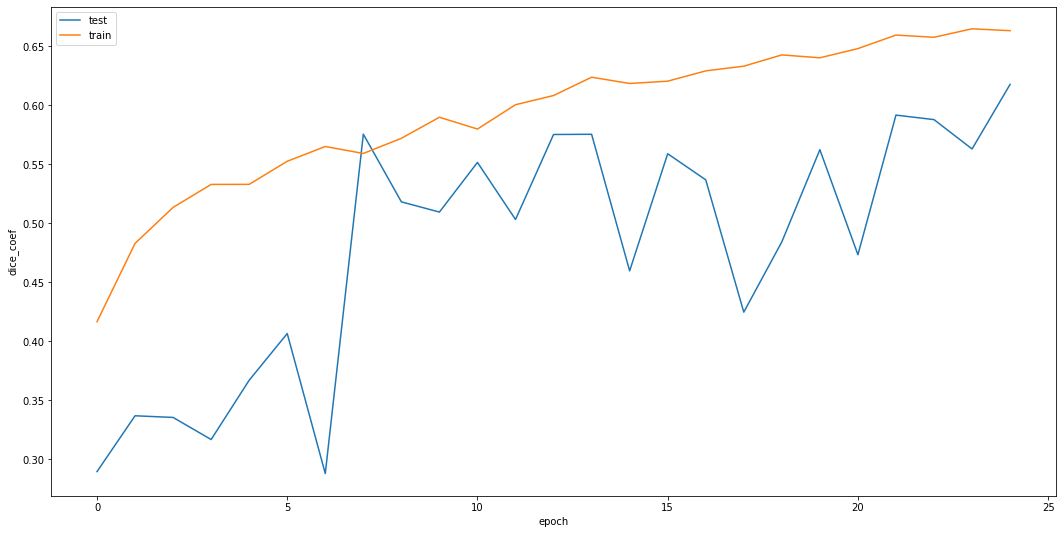

In [11]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

метрика на тесте ведет себя очень нестабильно, в то время как на трейне метрика растет

Посмотрим насколько хорошо получается разметка для отдельных классов.

In [12]:
pred = model_1.predict(X_val)
print(pred.shape)

(20, 256, 256, 19)


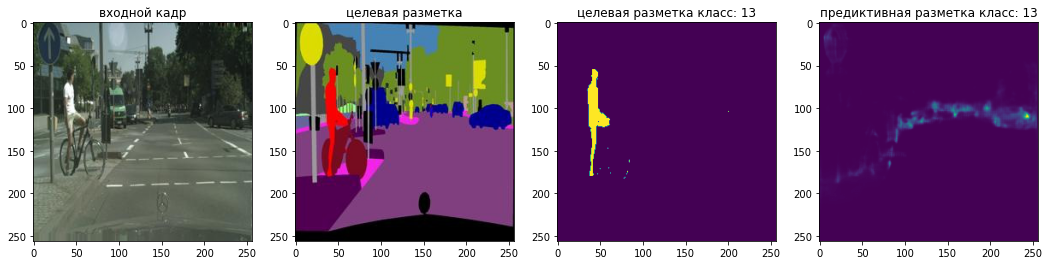

In [13]:
class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text(f'целевая разметка класс: {class_}')
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text(f'предиктивная разметка класс: {class_}')
plt.show()

Попробуем улучшить модель:

изменим функцию активации;

добавим специфичное определение начальных весов;

изменим оптимизатор и зададим коэффициент скорости обучения;

увеличим количество эпох обучения.

In [14]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('LeakyReLU')(x)

#     x = MaxPooling2D()(block_4_out)

#     Block 5
#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
#     x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = concatenate([x, block_4_out])
#     x = Conv2D(512, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

#     x = Conv2D(512, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=SGD(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [15]:
model_2 = Unet(19, (256, 256, 3))

# plot_model(model_2, to_file='model_2.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [16]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list


history = model_2.fit(X_train, train_labels, epochs=50, batch_size=1, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/50
80/80 [==============================] - ETA: 0s - loss: 1.7451 - dice_coef: 0.3384
Epoch 1: loss improved from inf to 1.74515, saving model to seg_model.h5
80/80 [==============================] - 23s 248ms/step - loss: 1.7451 - dice_coef: 0.3384 - val_loss: 2.2646 - val_dice_coef: 0.1642
Epoch 2/50
80/80 [==============================] - ETA: 0s - loss: 1.3022 - dice_coef: 0.4658
Epoch 2: loss improved from 1.74515 to 1.30224, saving model to seg_model.h5
80/80 [==============================] - 19s 241ms/step - loss: 1.3022 - dice_coef: 0.4658 - val_loss: 2.5601 - val_dice_coef: 0.3014
Epoch 3/50
80/80 [==============================] - ETA: 0s - loss: 1.2104 - dice_coef: 0.5078
Epoch 3: loss improved from 1.30224 to 1.21035, saving model to seg_model.h5
80/80 [==============================] - 20s 252ms/step - loss: 1.2104 - dice_coef: 0.5078 - val_loss: 1.9739 - val_dice_coef: 0.3386
Epoch 4/50
80/80 [==============================] - ETA: 0s - loss: 1.1288 - dice_coef

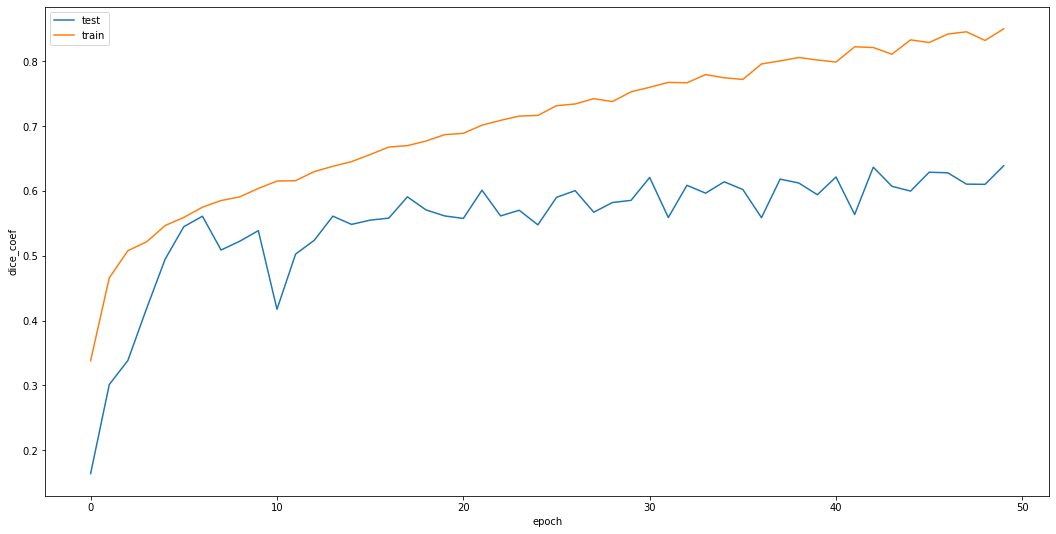

In [17]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Метрика на тесте для данной модели ведет себя более стабильно

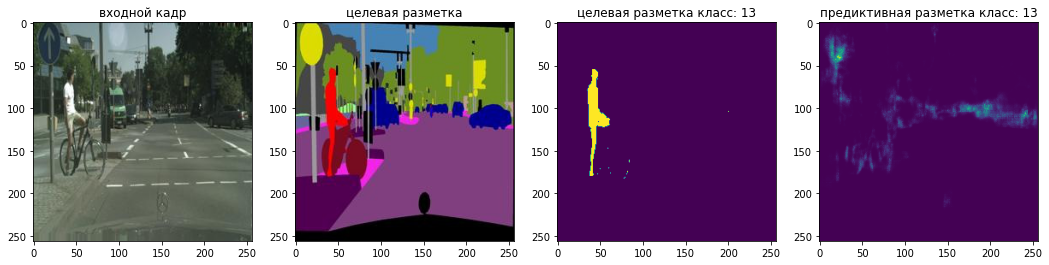

In [18]:
pred = model_2.predict(X_val)

class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text('целевая разметка класс: '+str(class_))
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text('предиктивная разметка класс: '+str(class_))
plt.show()

Сделаем еще одну итерацию модели - поменяем количество ядер, добавим еще одну пару слоев и увеличим размер батча.

In [19]:
def Unet(num_classes = 19, input_shape= (256, 256, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('LeakyReLU')(x)

    x = MaxPooling2D()(block_4_out)

#     Block 5
    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

#     UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('LeakyReLU')(x)

    # слой классификатор
    x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=SGD(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [20]:
model_3 = Unet(19, (256, 256, 3))

# plot_model(model_3, to_file='model_3.png', show_shapes=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_38 (BatchN  (None, 256, 256, 32  128        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [21]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('seg_model_3.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list


history = model_3.fit(X_train, train_labels, epochs=50, batch_size=2, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 2.3160 - dice_coef: 0.1965
Epoch 1: loss improved from inf to 2.31603, saving model to seg_model_3.h5
40/40 [==============================] - 24s 376ms/step - loss: 2.3160 - dice_coef: 0.1965 - val_loss: 2.6623 - val_dice_coef: 0.0789
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 1.7765 - dice_coef: 0.3343
Epoch 2: loss improved from 2.31603 to 1.77645, saving model to seg_model_3.h5
40/40 [==============================] - 14s 361ms/step - loss: 1.7765 - dice_coef: 0.3343 - val_loss: 2.4725 - val_dice_coef: 0.1357
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 1.5206 - dice_coef: 0.4030
Epoch 3: loss improved from 1.77645 to 1.52060, saving model to seg_model_3.h5
40/40 [==============================] - 14s 363ms/step - loss: 1.5206 - dice_coef: 0.4030 - val_loss: 2.4851 - val_dice_coef: 0.2054
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 1.3693 - dic

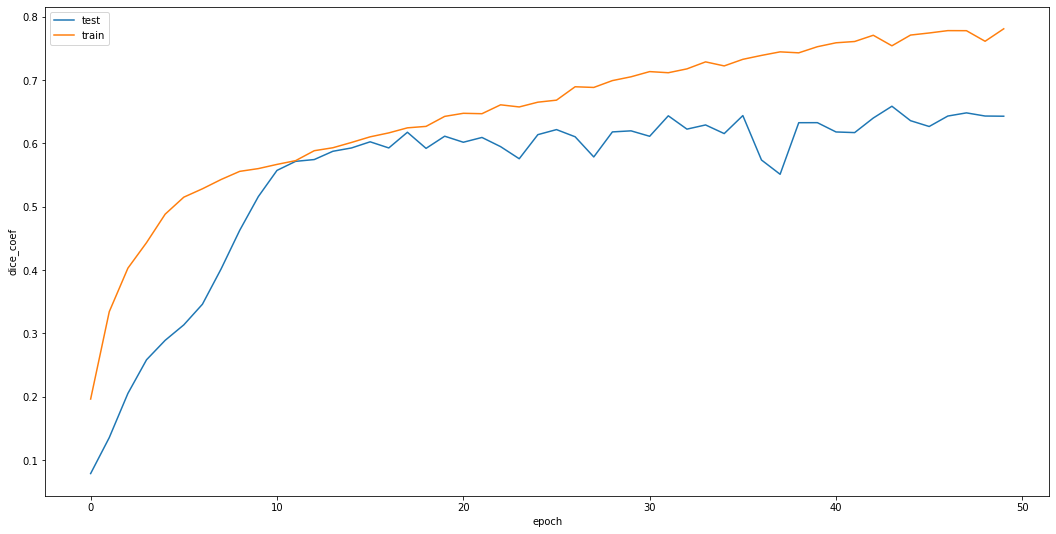

In [22]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

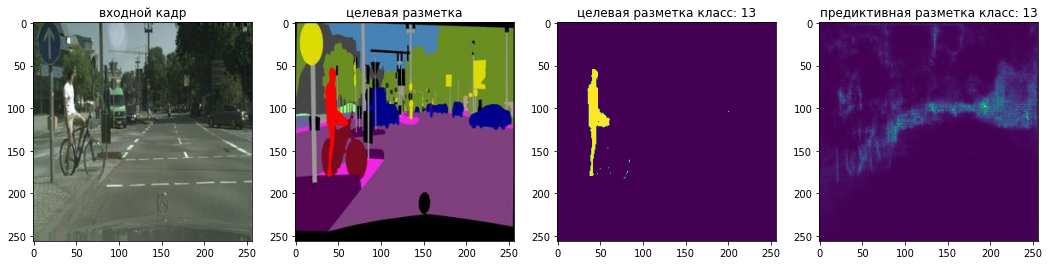

In [23]:
pred = model_3.predict(X_val)

class_ = 13
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[5])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[5])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[5][:,:,class_])
axes[2].title.set_text('целевая разметка класс: '+str(class_))
axes[3].imshow(pred[5][:,:,class_])
axes[3].title.set_text('предиктивная разметка класс: '+str(class_))
plt.show()